In [1]:

import pandas as pd
import numpy as np
import pickle
from datetime import datetime

import sys
sys.path.insert(0, "..")   
from src.model_utils import train
from src.plot_util import plot_all_sids_losses, plot_loss_per_sid, plot_median_iqr_loss



In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
today_str = datetime.today().strftime("%Y-%m-%d")
today_str

'2025-05-31'

In [4]:
# load
df = pd.read_excel("../output/data/20250530_train_top_10_store_10_item_sales_cyclical_features_16_days_X_y.xlsx")
#df = pd.read_excel("../output/data/20250539_train_top_10_store_10_item_sales_cyclical_features_16_days_X_y.xlsx")
df.head()

,start_date,store_item,store,item,dayofweek_sin_1,dayofweek_cos_1,weekofmonth_sin_1,weekofmonth_cos_1,monthofyear_sin_1,monthofyear_cos_1,...,y_item_med_day_7,y_item_med_day_8,y_item_med_day_9,y_item_med_day_10,y_item_med_day_11,y_item_med_day_12,y_item_med_day_13,y_item_med_day_14,y_item_med_day_15,y_item_med_day_16
0,2013-01-09,3_1047679,3,1047679,0.974928,-0.222521,0.587785,-0.809017,0.500000,8.660254e-01,...,62.5,89.5,148.0,142.5,102.0,76.0,79.0,70.0,79.5,95.0
1,2013-01-25,3_1047679,3,1047679,-0.433884,-0.900969,-0.951057,0.309017,0.500000,8.660254e-01,...,74.5,84.5,93.0,65.5,70.0,41.0,69.0,76.0,151.0,57.0
2,2013-02-10,3_1047679,3,1047679,-0.781831,0.623490,0.587785,-0.809017,0.866025,5.000000e-01,...,55.5,63.0,84.0,53.5,114.5,118.0,156.0,50.0,54.0,132.0
3,2013-02-26,3_1047679,3,1047679,0.781831,0.623490,-0.951057,0.309017,0.866025,5.000000e-01,...,80.5,51.0,68.5,135.5,157.0,89.0,30.0,62.0,86.0,107.0
4,2013-03-14,3_1047679,3,1047679,0.433884,-0.900969,0.587785,-0.809017,1.000000,6.123234e-17,...,120.5,188.0,204.0,103.0,54.0,73.5,58.5,98.5,178.0,225.5


In [5]:
df["start_date"].min(), df["start_date"].max()

(Timestamp('2013-01-09 00:00:00'), Timestamp('2017-07-15 00:00:00'))

In [6]:
df.dtypes

start_date           datetime64[ns]
store_item                   object
store                         int64
item                          int64
dayofweek_sin_1             float64
                          ...      
y_item_med_day_12           float64
y_item_med_day_13           float64
y_item_med_day_14           float64
y_item_med_day_15           float64
y_item_med_day_16           float64
Length: 292, dtype: object

In [7]:
df.columns

Index(['start_date', 'store_item', 'store', 'item', 'dayofweek_sin_1',
       'dayofweek_cos_1', 'weekofmonth_sin_1', 'weekofmonth_cos_1',
       'monthofyear_sin_1', 'monthofyear_cos_1',
       ...
       'y_item_med_day_7', 'y_item_med_day_8', 'y_item_med_day_9',
       'y_item_med_day_10', 'y_item_med_day_11', 'y_item_med_day_12',
       'y_item_med_day_13', 'y_item_med_day_14', 'y_item_med_day_15',
       'y_item_med_day_16'],
      dtype='object', length=292)

In [8]:
df.shape

(10386, 292)

In [9]:
window_size = 16

cyclical_features = (
    [f"dayofweek_sin_{i}" for i in range(1, window_size + 1)] +
    [f"dayofweek_cos_{i}" for i in range(1, window_size + 1)] +
    [f"weekofmonth_sin_{i}" for i in range(1, window_size + 1)] +
    [f"weekofmonth_cos_{i}" for i in range(1, window_size + 1)] +
    [f"monthofyear_sin_{i}" for i in range(1, window_size + 1)] +
    [f"monthofyear_cos_{i}" for i in range(1, window_size + 1)]
)

sales_features = (
    [f"sales_day_{i}" for i in range(1, window_size + 1)] +
    [f"store_med_day_{i}" for i in range(1, window_size + 1)] +
    [f"item_med_day_{i}" for i in range(1, window_size + 1)]
)

feature_cols = sales_features + cyclical_features
label_cols = [f"y_{c}" for c in feature_cols]
y_sales_features = [f"y_{c}" for c in sales_features]
y_cyclical_features = [f"y_{c}" for c in cyclical_features]
meta_cols = ["start_date", "store_item", "store", "item"]
df = df[meta_cols + feature_cols + label_cols]


In [10]:
df.head()

,start_date,store_item,store,item,sales_day_1,sales_day_2,sales_day_3,sales_day_4,sales_day_5,sales_day_6,...,y_monthofyear_cos_7,y_monthofyear_cos_8,y_monthofyear_cos_9,y_monthofyear_cos_10,y_monthofyear_cos_11,y_monthofyear_cos_12,y_monthofyear_cos_13,y_monthofyear_cos_14,y_monthofyear_cos_15,y_monthofyear_cos_16
0,2013-01-09,3_1047679,3,1047679,398.0,520.0,543.0,910.0,784.0,467.0,...,8.660254e-01,5.000000e-01,5.000000e-01,5.000000e-01,5.000000e-01,5.000000e-01,5.000000e-01,5.000000e-01,5.000000e-01,5.000000e-01
1,2013-01-25,3_1047679,3,1047679,224.0,520.0,474.0,251.0,302.0,288.0,...,5.000000e-01,5.000000e-01,5.000000e-01,5.000000e-01,5.000000e-01,5.000000e-01,5.000000e-01,5.000000e-01,5.000000e-01,5.000000e-01
2,2013-02-10,3_1047679,3,1047679,245.0,308.0,243.0,286.0,231.0,267.0,...,6.123234e-17,6.123234e-17,6.123234e-17,6.123234e-17,6.123234e-17,6.123234e-17,6.123234e-17,6.123234e-17,6.123234e-17,6.123234e-17
3,2013-02-26,3_1047679,3,1047679,173.0,352.0,231.0,292.0,525.0,736.0,...,6.123234e-17,6.123234e-17,6.123234e-17,6.123234e-17,6.123234e-17,6.123234e-17,6.123234e-17,6.123234e-17,6.123234e-17,6.123234e-17
4,2013-03-14,3_1047679,3,1047679,429.0,419.0,504.0,623.0,293.0,250.0,...,-5.000000e-01,-5.000000e-01,-5.000000e-01,-5.000000e-01,-5.000000e-01,-5.000000e-01,-5.000000e-01,-5.000000e-01,-5.000000e-01,-5.000000e-01


In [11]:
print(len(feature_cols))
print(len(label_cols))


144
144


In [12]:
# … shift & drop to build X, y …
# train_df = df.dropna(subset=[f'y_{c}' for c in feature_cols]).reset_index(drop=True)
# train_df.head()

In [13]:
weights_df= pd.read_excel("../output/data/top_10_item_weights.xlsx")

In [14]:
weights_df

,item,weight
0,114790,1.00
1,305229,1.00
2,314384,1.00
3,364606,1.00
4,502331,1.25
5,567623,1.00
6,581078,1.00
7,582864,1.25
8,584028,1.25
9,1047679,1.00


In [21]:
hist_df, summary_df, models_dict = train(
    df            = df,
    weights_df    = weights_df,
    feature_cols  = feature_cols,
    label_cols    = label_cols,
    y_cyclical_features = y_cyclical_features,
    y_sales_features = y_sales_features,
    item_col      = "item",
    train_frac    = 0.8,
    batch_size    = 32,
    lr            = 1e-3,
    epochs        = 100,
    seed          = 2025
    )    

[3_1047679] Epoch 1/100 train_RMSLE 5.0358, train_MAE 54.4542, test_RMSLE 0.3967, test_MAE 45.8572
[3_1047679] Epoch 2/100 train_RMSLE 4.6681, train_MAE 50.5722, test_RMSLE 0.3644, test_MAE 43.2828
[3_1047679] Epoch 3/100 train_RMSLE 4.2811, train_MAE 47.3428, test_RMSLE 0.3353, test_MAE 42.4029
[3_1047679] Epoch 4/100 train_RMSLE 3.9598, train_MAE 46.0476, test_RMSLE 0.3139, test_MAE 43.4005
[3_1047679] Epoch 5/100 train_RMSLE 3.7333, train_MAE 46.0783, test_RMSLE 0.2979, test_MAE 45.1646
[3_1047679] Epoch 6/100 train_RMSLE 3.5480, train_MAE 45.5442, test_RMSLE 0.2841, test_MAE 46.1583
[3_1047679] Epoch 7/100 train_RMSLE 3.3749, train_MAE 44.6786, test_RMSLE 0.2719, test_MAE 45.0886
[3_1047679] Epoch 8/100 train_RMSLE 3.2297, train_MAE 43.0992, test_RMSLE 0.2622, test_MAE 44.1241
[3_1047679] Epoch 9/100 train_RMSLE 3.1186, train_MAE 42.3037, test_RMSLE 0.2554, test_MAE 43.9290
[3_1047679] Epoch 10/100 train_RMSLE 3.0461, train_MAE 42.2844, test_RMSLE 0.2511, test_MAE 43.9298
[3_104767

In [22]:
hist_df.head(3)


,store_item,epoch,train_loss,train_mae,test_loss,test_mae
0,3_1047679,1,5.035821,54.454190,0.396742,45.857158
1,3_1047679,2,4.668066,50.572160,0.364432,43.282816
2,3_1047679,3,4.281061,47.342832,0.335343,42.402933


In [23]:
summary_df.head(3)

,store_item,final_train_loss,final_test_loss
0,3_1047679,1.764331,0.160406
1,3_114790,1.601999,0.161830
2,3_305229,2.051984,0.183497


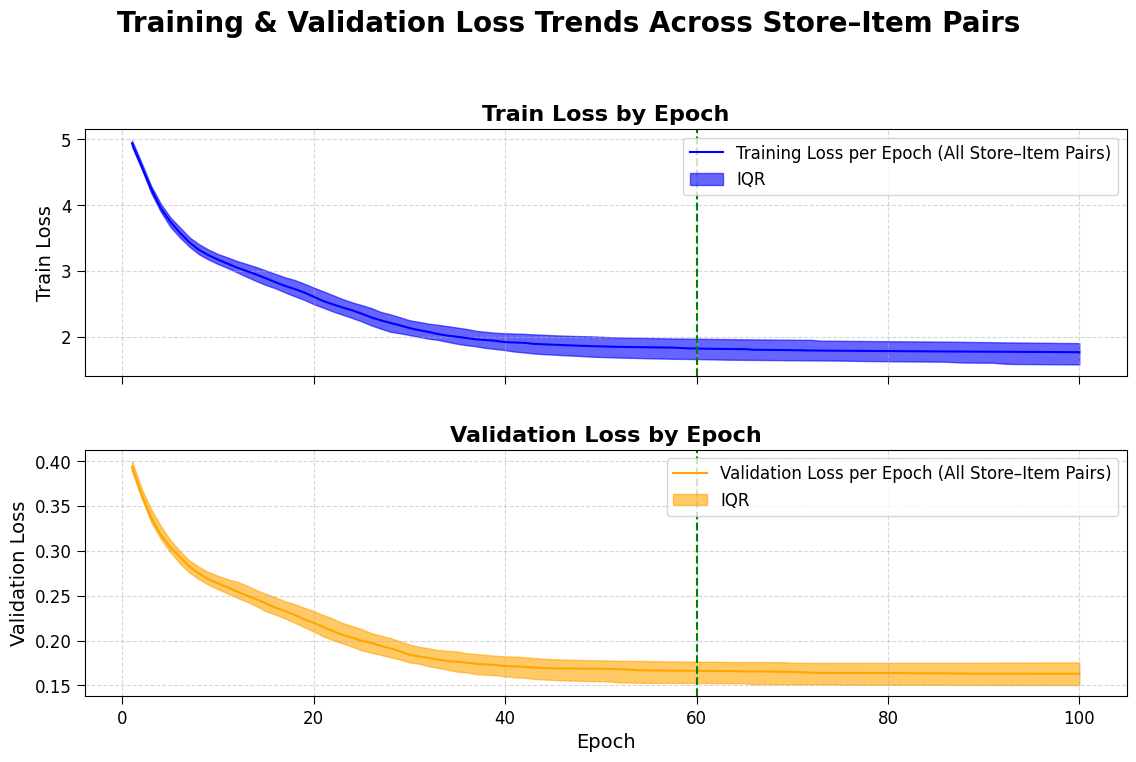

In [24]:
# plot_all_sids_losses(hist_df, 
#                      overall_title="Loss Curves for All Store Items",
# fn=f"../output/figures/all_sids_loss_curves_{today_str}.tiff")
plot_median_iqr_loss(hist_df, 
                     overall_title="Training & Validation Loss Trends Across Store–Item Pairs",
                     xvline=60,
fn=f"../output/figures/median_iqr_loss_curves_{today_str}.tiff")


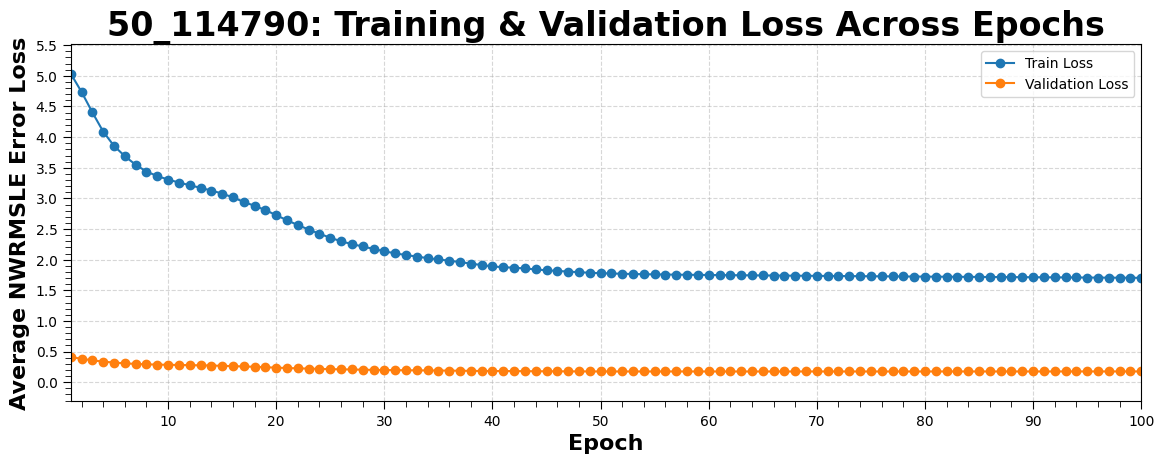

In [25]:
# to plot a single sid:
sid = "50_114790"
title = f"{sid}: Training & Validation Loss Across Epochs"
plot_loss_per_sid(hist_df, title = title,  
                  sid=sid, fn=f"../output/figures/loss_curves_{sid}_{today_str}.tiff",
                  train_col="train_loss", test_col="test_loss", y_label="Average NWRMSLE Error Loss")

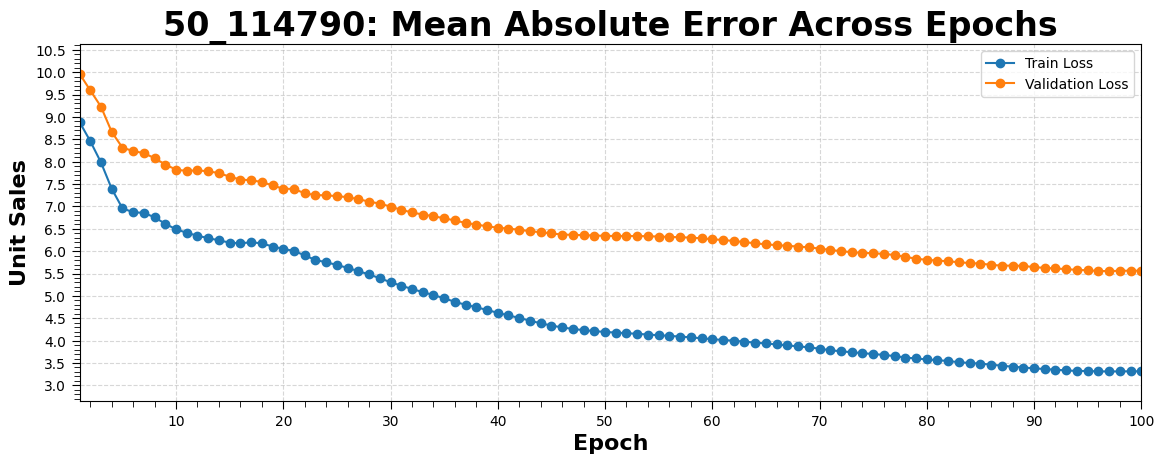

In [26]:
sid = "50_114790"
title = f"{sid}: Mean Absolute Error Across Epochs"
plot_loss_per_sid(hist_df, title=title, 
                  sid=sid, fn=f"../output/figures/loss_curves_mae_{sid}_{today_str}.tiff", 
                  train_col="train_mae", test_col="test_mae", y_label="Unit Sales")